In [0]:
!pip install nba-api
!pip install Keras

     |████████████████████████████████| 225kB 9.3MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import pandas as pd
from pandas import ExcelFile
from pandas.plotting import scatter_matrix
import numpy as np
from datetime import datetime
import time
import requests
import json

import matplotlib.pyplot as plt

import nba_api
from nba_api.stats.static import teams
from nba_api.stats.endpoints import LeagueGameFinder, LeagueGameLog, PlayerGameLog
from nba_api.stats.endpoints import BoxScoreDefensive, BoxScoreMiscV2, BoxScorePlayerTrackV2, BoxScoreUsageV2

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, Normalizer, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

-------
# csv dataset
-------

In [29]:
# df_final = pd.read_csv('nba_gamedata_201819.csv')
# df_final = pd.read_csv('gamedata_final.csv')
df_final = pd.read_csv('gamedata_final_reduced.csv')

# df_final = pd.read_csv('/content/drive/My Drive/nba_ml/current edition/nba_gamedata_201819.csv')

In [30]:
df_final

,SEASON_ID,PLAYER_ID,GAME_ID,GAME_DATE_x,MATCHUP,WL,MIN_x,FGM,FGA,FG_PCT_x,...,PCT_DREB,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS
0,22018,203500,21801226,10-Apr-19,OKC @ MIL,W,12,1,5,0.200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22018,203500,21801218,9-Apr-19,OKC vs. HOU,W,37,3,11,0.273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22018,203500,21801197,7-Apr-19,OKC @ MIN,W,27,4,5,0.800,...,0.174,0.207,0.056,0.300,0.200,0.000,0.000,0.353,0.167,0.092
3,22018,203500,21801186,5-Apr-19,OKC vs. DET,W,24,7,9,0.778,...,0.273,0.424,0.000,0.222,0.000,1.000,0.000,0.364,0.000,0.226
4,22018,203500,21801161,2-Apr-19,OKC vs. LAL,W,33,6,11,0.545,...,0.042,0.205,0.111,0.333,0.091,0.833,0.500,0.250,0.389,0.141
5,22018,203500,21801146,31-Mar-19,OKC vs. DAL,L,39,10,17,0.588,...,0.214,0.349,0.111,0.000,0.000,0.400,0.000,0.111,0.200,0.233
6,22018,203500,21801133,29-Mar-19,OKC vs. DEN,L,35,8,12,0.667,...,0.158,0.200,0.125,0.111,0.000,0.333,0.000,0.000,0.063,0.186
7,22018,203500,21801119,27-Mar-19,OKC vs. IND,W,35,11,14,0.786,...,0.192,0.343,0.136,0.000,0.286,0.200,0.200,0.111,0.214,0.298
8,22018,203500,21801104,25-Mar-19,OKC @ MEM,L,32,1,7,0.143,...,0.111,0.296,0.000,0.167,0.800,1.000,0.000,0.154,0.000,0.030
9,22018,203500,21801083,22-Mar-19,OKC @ TOR,W,33,4,9,0.444,...,0.053,0.167,0.045,0.111,0.250,0.600,0.000,0.143,0.158,0.110


In [5]:
list(df_final.keys())

['Unnamed: 0',
 'Column1',
 'SEASON_ID',
 'PLAYER_ID',
 'GAME_ID',
 'GAME_DATE_x',
 'MATCHUP',
 'WL',
 'MIN_x',
 'FGM',
 'FGA',
 'FG_PCT_x',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB_x',
 'REB',
 'AST_x',
 'STL_x',
 'BLK_x',
 'TOV',
 'PF_x',
 'PTS',
 'PLUS_MINUS',
 'VIDEO_AVAILABLE',
 'TEAM_ID',
 'TEAM_ABBREVIATION_x',
 'TEAM_CITY_x',
 'PLAYER_NAME_x',
 'START_POSITION_x',
 'COMMENT_x',
 'MIN_y',
 'E_OFF_RATING',
 'OFF_RATING',
 'E_DEF_RATING',
 'DEF_RATING',
 'E_NET_RATING',
 'NET_RATING',
 'AST_PCT',
 'AST_TOV',
 'AST_RATIO',
 'OREB_PCT',
 'DREB_PCT',
 'REB_PCT',
 'TM_TOV_PCT',
 'EFG_PCT',
 'TS_PCT',
 'USG_PCT_x',
 'E_USG_PCT',
 'E_PACE',
 'PACE',
 'PACE_PER40',
 'POSS',
 'PIE',
 'Gamescore',
 'FT_missed',
 'GAME_DATE_y',
 'attendance',
 'arena',
 'City',
 'Hometeam',
 'Capacity',
 'Year Built',
 'Home/Away',
 'Capacity_pct',
 'TEAM_ABBREVIATION_y',
 'TEAM_CITY_y',
 'TEAM_NICKNAME',
 'PLAYER_NAME_y',
 'START_POSITION_y',
 'COMMENT_y',
 'MATCHUP_MIN',
 '

In [0]:
df_final['arena'].unique()

array(['Fiserv Forum', 'Chesapeake Energy Arena', 'Target Center',
       'FedEx Forum', 'Scotiabank Arena', 'Bankers Life Fieldhouse',
       'Vivint Smart Home Arena', 'Staples Center', 'Moda Center',
       'AT&T Center', 'Pepsi Center', 'Smoothie King Center',
       'Toyota Center', 'TD Garden', 'American Airlines Arena',
       'Madison Square Garden', 'Wells Fargo Center', 'State Farm Arena',
       'American Airlines Center', 'Talking Stick Resort Arena',
       'Golden 1 Center', 'United Center', 'Barclays Center',
       'Little Caesars Arena', 'ORACLE Arena', 'Quicken Loans Arena',
       'Capital One Arena', 'Spectrum Center', 'Amway Center',
       'Arena Ciudad de Mexico', 'The O2 Arena',
       'Rocket Mortgage FieldHouse'], dtype=object)

In [31]:
# fix gameid column w/ leading zeros
df_final['GAME_ID'] = df_final['GAME_ID'].map(lambda x: f'{x:0>10}')

In [32]:
df_final.head()

,SEASON_ID,PLAYER_ID,GAME_ID,GAME_DATE_x,MATCHUP,WL,MIN_x,FGM,FGA,FG_PCT_x,...,PCT_DREB,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS
0,22018,203500,0021801226,10-Apr-19,OKC @ MIL,W,12,1,5,0.200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22018,203500,0021801218,9-Apr-19,OKC vs. HOU,W,37,3,11,0.273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22018,203500,0021801197,7-Apr-19,OKC @ MIN,W,27,4,5,0.800,...,0.174,0.207,0.056,0.300,0.200,0.000,0.0,0.353,0.167,0.092
3,22018,203500,0021801186,5-Apr-19,OKC vs. DET,W,24,7,9,0.778,...,0.273,0.424,0.000,0.222,0.000,1.000,0.0,0.364,0.000,0.226
4,22018,203500,0021801161,2-Apr-19,OKC vs. LAL,W,33,6,11,0.545,...,0.042,0.205,0.111,0.333,0.091,0.833,0.5,0.250,0.389,0.141


# add more stats

In [33]:
test_array = df_final['GAME_ID'].unique()[:10]
unique_array = df_final['GAME_ID'].unique()
test_df = df_final.copy()

In [11]:
missing_games = [
'0021801226',
'0021801218'
]

In [13]:
df_def_list = []
df_misc_list = []
df_tracking_list = []
df_usage_list = []

startTime = datetime.now()

game_ok_count = 0
game_no_count = 0

game_problem_list = []

for game in missing_games:
  
    try:

        print(f'Searching for game: {game}...')

        df_defensive = BoxScoreDefensive(game_id=game).get_data_frames()[0]
        time.sleep(1)
        print(f' 1.Defensive df found and saved')

        df_misc = BoxScoreMiscV2(game_id=game).get_data_frames()[0]
        time.sleep(1)
        print(f' 2.Misc df found and saved')

        df_tracking = BoxScorePlayerTrackV2(game_id=game).get_data_frames()[0]
        time.sleep(1)
        print(f' 3.Tracking df found and saved')

        df_usage = BoxScoreUsageV2(game_id=game).get_data_frames()[0]
        time.sleep(1)
        print(f' 4.Usage df found and saved')

#         x, = np.where(unique_array == game)
        x, = np.where(missing_games == game)

        game_ok_count += 1

        print(f'--- {x+1} games searched ---')
        print(f'--- {game_ok_count} games found ---')

        time.sleep(5)

        df_def_list.append(df_defensive)
        df_misc_list.append(df_misc)
        df_tracking_list.append(df_tracking)
        df_usage_list.append(df_usage)

        print(f'--- {game_ok_count} games appended ---')

        print(f'--- Time: {datetime.now() - startTime} ---')

    except:
    
    #   problem list
        game_no_count += 1

        game_problem_list.append(game)

        print(f'game {game} encountered timeout')
        print(f'--- {game_no_count} games with problems ---')

    #   sleep
        print(f'--- sleeping for 300 seconds ---')
        time.sleep(300)

    #   try again to search
        try:

            print(f'Searching again for game: {game}...')

            df_defensive = BoxScoreDefensive(game_id=game).get_data_frames()[0]
            time.sleep(1)
            print(f' 1.Defensive df found and saved')

            df_misc = BoxScoreMiscV2(game_id=game).get_data_frames()[0]
            time.sleep(1)
            print(f' 2.Misc df found and saved')

            df_tracking = BoxScorePlayerTrackV2(game_id=game).get_data_frames()[0]
            time.sleep(1)
            print(f' 3.Tracking df found and saved')

            df_usage = BoxScoreUsageV2(game_id=game).get_data_frames()[0]
            time.sleep(1)
            print(f' 4.Usage df found and saved')

            x, = np.where(unique_array == game)

            game_ok_count += 1

            print(f'--- {x+1} games searched ---')
            print(f'--- {game_ok_count} games found ---')

            time.sleep(5)

            df_def_list.append(df_defensive)
            df_misc_list.append(df_misc)
            df_tracking_list.append(df_tracking)
            df_usage_list.append(df_usage)

            print(f'--- {game_ok_count} games appended ---')

            print(f'--- Time: {datetime.now() - startTime} ---')

        except:

            print(f'game {game} encountered another timeout')
            print(f'--- {game_no_count} games with problems ---')

        #   sleep
            print(f'--- sleeping for 300 seconds ---')
            time.sleep(300)

            continue

    continue

# df_def_all = pd.concat(df_def_list)
# df_misc_all = pd.concat(df_misc_list)
# df_tracking_all = pd.concat(df_tracking_list)
# df_usage_all = pd.concat(df_usage_list)

df_def_missing = pd.concat(df_def_list)
df_misc_missing = pd.concat(df_misc_list)
df_tracking_missing = pd.concat(df_tracking_list)
df_usage_missing = pd.concat(df_usage_list)

print(f'--- merged df ---')

Searching for game: 0021801226...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [] games searched ---
--- 1 games found ---
--- 1 games appended ---
--- Time: 0:00:18.868132 ---
Searching for game: 0021801218...
 1.Defensive df found and saved
 2.Misc df found and saved
 3.Tracking df found and saved
 4.Usage df found and saved
--- [] games searched ---
--- 2 games found ---
--- 2 games appended ---
--- Time: 0:00:39.509262 ---
--- merged df ---


In [221]:
df_def_all.to_csv('defensive.csv')
df_misc_all.to_csv('misc.csv')
df_tracking_all.to_csv('tracking.csv')
df_usage_all.to_csv('usage.csv')

In [22]:
# stats_df = test_df.merge(df_def_all, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')
stats_df = test_df.merge(df_def_missing, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')

In [23]:
# stats_df = test_df.merge(df_misc_all, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')
stats_df = test_df.merge(df_misc_missing, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')

In [24]:
# stats_df = test_df.merge(df_tracking_all, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')
stats_df = test_df.merge(df_tracking_missing, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')

In [25]:
# stats_df = test_df.merge(df_usage_all, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')
stats_df = test_df.merge(df_usage_missing, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')

In [26]:
stats_df

,Unnamed: 0,Column1,SEASON_ID,PLAYER_ID,GAME_ID,GAME_DATE_x,MATCHUP,WL,MIN_x,FGM,...,PCT_DREB_y,PCT_REB_y,PCT_AST_y,PCT_TOV_y,PCT_STL_y,PCT_BLK_y,PCT_BLKA_y,PCT_PF_y,PCT_PFD_y,PCT_PTS_y
0,0,0.0,22018.0,203500.0,0021801226,10-Apr-19,OKC @ MIL,W,12.0,1.0,...,0.000,0.167,0.000,0.000,0.000,1.000,0.000,0.200,0.500,0.118
1,1,1.0,22018.0,203500.0,0021801218,9-Apr-19,OKC vs. HOU,W,37.0,3.0,...,0.179,0.289,0.067,0.000,0.000,0.000,0.000,0.059,0.167,0.093
2,3204,3212.0,22018.0,1628425.0,0021801226,10-Apr-19,MIL vs. OKC,L,23.0,2.0,...,0.158,0.130,0.333,0.429,0.000,0.000,0.333,0.571,0.167,0.152
3,3644,3652.0,22018.0,1629126.0,0021801226,10-Apr-19,OKC @ MIL,W,1.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,3857,3865.0,22018.0,203991.0,0021801218,9-Apr-19,HOU @ OKC,L,36.0,8.0,...,0.269,0.313,0.231,0.375,0.000,0.429,0.000,0.167,0.188,0.243
5,4779,4788.0,22018.0,1626192.0,0021801226,10-Apr-19,MIL vs. OKC,L,18.0,5.0,...,0.133,0.263,0.100,0.400,0.250,0.000,0.333,0.222,0.000,0.293
6,6855,6866.0,22018.0,1628390.0,0021801226,10-Apr-19,OKC @ MIL,W,33.0,4.0,...,0.207,0.200,0.185,0.429,0.000,0.000,0.000,0.250,0.000,0.128
7,6856,6867.0,22018.0,1628390.0,0021801218,9-Apr-19,OKC vs. HOU,W,26.0,6.0,...,0.136,0.088,0.077,0.333,0.000,0.000,0.000,0.273,0.167,0.262
8,7324,7336.0,22018.0,204025.0,0021801226,10-Apr-19,MIL vs. OKC,L,48.0,10.0,...,0.119,0.113,0.481,0.200,0.000,1.000,0.000,0.143,0.350,0.250
9,7737,7750.0,22018.0,202331.0,0021801218,9-Apr-19,OKC vs. HOU,W,42.0,9.0,...,0.235,0.191,0.158,0.200,1.000,0.000,0.600,0.286,0.444,0.273


In [228]:
# stats_df.to_csv('test.csv')


In [106]:
list(test_df.keys())

['Column1',
 'SEASON_ID',
 'PLAYER_ID',
 'GAME_ID',
 'GAME_DATE_x',
 'MATCHUP',
 'WL',
 'MIN_x',
 'FGM',
 'FGA',
 'FG_PCT_x',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB_x',
 'REB',
 'AST_x',
 'STL_x',
 'BLK_x',
 'TOV',
 'PF_x',
 'PTS',
 'PLUS_MINUS',
 'VIDEO_AVAILABLE',
 'TEAM_ID',
 'TEAM_ABBREVIATION_x',
 'TEAM_CITY_x',
 'PLAYER_NAME_x',
 'START_POSITION_x',
 'COMMENT_x',
 'MIN_y',
 'E_OFF_RATING',
 'OFF_RATING',
 'E_DEF_RATING',
 'DEF_RATING',
 'E_NET_RATING',
 'NET_RATING',
 'AST_PCT',
 'AST_TOV',
 'AST_RATIO',
 'OREB_PCT',
 'DREB_PCT',
 'REB_PCT',
 'TM_TOV_PCT',
 'EFG_PCT',
 'TS_PCT',
 'USG_PCT_x',
 'E_USG_PCT',
 'E_PACE',
 'PACE',
 'PACE_PER40',
 'POSS',
 'PIE',
 'Gamescore',
 'FT_missed',
 'GAME_DATE_y',
 'attendance',
 'arena',
 'City',
 'Hometeam',
 'Capacity',
 'Year Built',
 'Home/Away',
 'Capacity_pct',
 'TEAM_ABBREVIATION_y',
 'TEAM_CITY_y',
 'TEAM_NICKNAME',
 'PLAYER_NAME_y',
 'START_POSITION_y',
 'COMMENT_y',
 'MATCHUP_MIN',
 'PARTIAL_POSS',


In [112]:
test_df

0        OKC
1        OKC
2        OKC
3        OKC
4        OKC
5        OKC
6        OKC
7        OKC
8        OKC
9        OKC
10       NaN
11       NaN
12       NaN
13       NaN
14       NaN
15       NaN
16       NaN
17       NaN
18       NaN
19       NaN
20       NaN
21       NaN
22       NaN
23       NaN
24       NaN
25       NaN
26       NaN
27       NaN
28       NaN
29       NaN
        ... 
22631    DAL
22632    DAL
22633    OKC
22634    OKC
22635    OKC
22636    DEN
22637    DEN
22638    DEN
22639    OKC
22640    IND
22641    IND
22642    IND
22643    IND
22644    OKC
22645    OKC
22646    OKC
22647    OKC
22648    OKC
22649    OKC
22650    OKC
22651    MEM
22652    MEM
22653    MEM
22654    OKC
22655    OKC
22656    OKC
22657    OKC
22658    TOR
22659    TOR
22660    TOR
Name: TEAM_ABBREVIATION, Length: 22661, dtype: object

In [36]:
boxscored.keys()

Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'TEAM_NICKNAME',
       'PLAYER_ID', 'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MATCHUP_MIN',
       'PARTIAL_POSS', 'SWITCHES_ON', 'PLAYER_PTS', 'DREB', 'MATCHUP_AST',
       'MATCHUP_TOV', 'STL', 'BLK', 'MATCHUP_FGM', 'MATCHUP_FGA',
       'MATCHUP_FG_PCT', 'MATCHUP_FG3M', 'MATCHUP_FG3A', 'MATCHUP_FG3_PCT'],
      dtype='object')

In [77]:
df_final.keys()

Index(['Column1', 'SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE_x',
       'MATCHUP', 'WL', 'MIN_x', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_NAME', 'START_POSITION',
       'COMMENT', 'MIN_y', 'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING',
       'DEF_RATING', 'E_NET_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV',
       'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT',
       'TS_PCT', 'USG_PCT', 'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40',
       'POSS', 'PIE', 'Gamescore', 'FT_missed', 'GAME_DATE_y', 'attendance',
       'arena', 'City', 'Hometeam', 'Capacity', 'Year Built', 'Home/Away'],
      dtype='object')

In [72]:
test_df.to_csv('test.csv')

----
# simple neural net
----

In [35]:
df = pd.read_csv('gamedata_test_reduced.csv')

In [36]:
df

,SEASON_ID,PLAYER_ID,GAME_ID,GAME_DATE_x,MATCHUP,WL,MIN_x,FGM,FGA,FG_PCT_x,...,PCT_DREB,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS
0,22018,203500,21801197,7-Apr-19,OKC @ MIN,W,27,4,5,0.800,...,0.174,0.207,0.056,0.300,0.200,0.000,0.000,0.353,0.167,0.092
1,22018,203500,21801186,5-Apr-19,OKC vs. DET,W,24,7,9,0.778,...,0.273,0.424,0.000,0.222,0.000,1.000,0.000,0.364,0.000,0.226
2,22018,203500,21801161,2-Apr-19,OKC vs. LAL,W,33,6,11,0.545,...,0.042,0.205,0.111,0.333,0.091,0.833,0.500,0.250,0.389,0.141
3,22018,203500,21801146,31-Mar-19,OKC vs. DAL,L,39,10,17,0.588,...,0.214,0.349,0.111,0.000,0.000,0.400,0.000,0.111,0.200,0.233
4,22018,203500,21801133,29-Mar-19,OKC vs. DEN,L,35,8,12,0.667,...,0.158,0.200,0.125,0.111,0.000,0.333,0.000,0.000,0.063,0.186
5,22018,203500,21801119,27-Mar-19,OKC vs. IND,W,35,11,14,0.786,...,0.192,0.343,0.136,0.000,0.286,0.200,0.200,0.111,0.214,0.298
6,22018,203500,21801104,25-Mar-19,OKC @ MEM,L,32,1,7,0.143,...,0.111,0.296,0.000,0.167,0.800,1.000,0.000,0.154,0.000,0.030
7,22018,203500,21801083,22-Mar-19,OKC @ TOR,W,33,4,9,0.444,...,0.053,0.167,0.045,0.111,0.250,0.600,0.000,0.143,0.158,0.110
8,22018,203500,21801072,20-Mar-19,OKC vs. TOR,L,40,2,7,0.286,...,0.000,0.171,0.133,0.133,0.250,0.000,0.000,0.200,0.118,0.045
9,22018,203500,21801054,18-Mar-19,OKC vs. MIA,L,25,5,6,0.833,...,0.381,0.414,0.231,0.182,0.500,0.400,0.000,0.545,0.154,0.169


In [0]:
df_nnet = df[['WL', 'Gamescore', 'PACE', 'PIE', 'attendance']].copy()

In [0]:
df_nnet['attendance_scaled'] = df_nnet['attendance']/1000

In [0]:
df_nnet = df_nnet.drop(columns = ['attendance'])

In [0]:
df_nnet.head()

In [0]:
data = df_nnet.copy()

In [0]:
encoder = LabelEncoder()
encoder.fit(data['WL'])
encoder.classes_

In [0]:
y = encoder.transform(data.WL)
y

In [0]:
data.drop(columns=['WL'], inplace=True)
X = data.values

In [0]:
len(y)

In [0]:
len(X)

In [0]:
y_categorical = to_categorical(y)
len(y_categorical)

In [0]:
y_categorial

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, random_state=1)

In [0]:
X_scaler = StandardScaler().fit(X_train)

In [0]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [0]:
y_scaler = StandardScaler().fit(y_train)

In [0]:
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [0]:
X_train_scaled[1]

In [0]:
X_min_max_scaler = MinMaxScaler().fit(X_train)
y_min_max_scaler = MinMaxScaler().fit(y_train)

In [0]:
X_train_min_max_scaled = X_min_max_scaler.transform(X_train)
X_test_min_max_scaled = X_min_max_scaler.transform(X_test)

y_train_min_max_scaled = y_min_max_scaler.transform(y_train)
y_test_min_max_scaled = y_min_max_scaler.transform(y_test)

In [0]:
X_train_min_max_scaled.shape

In [0]:
y_train_min_max_scaled.shape

In [0]:
X_train_min_max_scaled

In [0]:
y_train_min_max_scaled

In [0]:
xxx = X_train_scaled[:5000]
xxx_test = X_test_scaled[:5000]
yyy = y_train_scaled[:5000]
yyy_test = y_test_scaled[:5000]

In [0]:
model = Sequential(name='NBA_Model')
model.add(Dense(units=6, activation='relu', input_dim=4))
model.add(Dense(units=2, activation='softmax'))

In [0]:
model.summary()

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
print(len(X_train_scaled), ',' , len(y_train_scaled))

In [0]:
model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=1000,
    shuffle=True,
    verbose=2
)

In [0]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test, verbose=2)
print(f"Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

--------
# svc model (grid)
--------

In [0]:
df_final.keys()

Index(['Column1', 'SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE_x',
       'MATCHUP', 'WL', 'MIN_x', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_NAME', 'START_POSITION',
       'COMMENT', 'MIN_y', 'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING',
       'DEF_RATING', 'E_NET_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV',
       'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT',
       'TS_PCT', 'USG_PCT', 'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40',
       'POSS', 'PIE', 'Gamescore', 'FT_missed', 'GAME_DATE_y', 'attendance',
       'arena', 'City', 'Hometeam', 'Capacity', 'Year Built', 'Home/Away',
       'Capacity_pct'],
      dtype='object')

In [118]:
df_svc = df_final[['WL', 'PTS','PF', 'TOV','FT_missed','AST_TOV', 'OFF_RATING', 'DEF_RATING', 
                   'POSS', 'USG_PCT', 'FG3_PCT', 'Capacity_pct']].copy()

In [119]:
df_svc.fillna(value=0)

,WL,PTS,PF,TOV,FT_missed,AST_TOV,OFF_RATING,DEF_RATING,POSS,USG_PCT,FG3_PCT,Capacity_pct
0,W,4,1,0,2,0.00,109.7,120.7,31,0.206,0.0,1.033257
1,W,8,1,0,2,0.00,116.2,115.1,74,0.137,0.0,1.000000
2,W,8,6,3,0,0.33,145.0,93.3,60,0.119,0.0,1.000000
3,W,14,4,2,0,0.00,117.0,113.0,53,0.169,0.0,1.000000
4,W,13,2,2,6,1.50,129.6,94.3,71,0.180,0.0,1.000000
5,L,20,2,0,3,0.00,107.5,96.2,80,0.184,0.0,1.000000
6,L,16,0,1,1,2.00,124.6,120.0,69,0.165,0.0,1.000000
7,W,25,1,0,3,0.00,115.1,98.6,73,0.202,0.0,1.000000
8,L,2,2,1,0,0.00,95.7,124.6,69,0.103,0.0,0.851073
9,W,9,2,1,1,1.00,124.2,107.5,66,0.139,0.0,1.010808


In [120]:
encoder = LabelEncoder()
encoder.fit(df_svc['WL'])
y = encoder.transform(df_svc.WL)
df_svc['y'] = y

In [121]:
df_svc

,WL,PTS,PF,TOV,FT_missed,AST_TOV,OFF_RATING,DEF_RATING,POSS,USG_PCT,FG3_PCT,Capacity_pct,y
0,W,4,1,0,2,0.00,109.7,120.7,31,0.206,0.0,1.033257,1
1,W,8,1,0,2,0.00,116.2,115.1,74,0.137,0.0,1.000000,1
2,W,8,6,3,0,0.33,145.0,93.3,60,0.119,0.0,1.000000,1
3,W,14,4,2,0,0.00,117.0,113.0,53,0.169,0.0,1.000000,1
4,W,13,2,2,6,1.50,129.6,94.3,71,0.180,0.0,1.000000,1
5,L,20,2,0,3,0.00,107.5,96.2,80,0.184,0.0,1.000000,0
6,L,16,0,1,1,2.00,124.6,120.0,69,0.165,0.0,1.000000,0
7,W,25,1,0,3,0.00,115.1,98.6,73,0.202,0.0,1.000000,1
8,L,2,2,1,0,0.00,95.7,124.6,69,0.103,0.0,0.851073,0
9,W,9,2,1,1,1.00,124.2,107.5,66,0.139,0.0,1.010808,1


In [122]:
target = df_svc['y']
data = df_svc[['PTS','PF', 'TOV','FT_missed','AST_TOV', 'OFF_RATING', 'DEF_RATING', 
                   'POSS', 'USG_PCT', 'FG3_PCT', 'Capacity_pct']]
features = data.columns

In [123]:
# X_train, X_test, y_train, y_test = train_test_split(data[:5000], target[:5000], random_state=42)

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [124]:
y_test.head()

7976     1
13855    1
3668     1
9117     0
22455    1
Name: y, dtype: int64

In [0]:
model = SVC(kernel='linear',verbose=True)
model.fit(X_train, y_train)

[LibSVM]

In [0]:
predictions = model.predict(X_test)

In [0]:
predictions

In [0]:
print(classification_report(y_test, predictions))

## grid

In [125]:
model = SVC()
param_grid = {'C': [5, 10, 100],
              'gamma': [0.01, 1, 10, 100],
              'kernel':['rbf']}
grid = GridSearchCV(model, param_grid, verbose=3)

In [126]:
grid.fit(X_train, y_train)

/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=5, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=5, gamma=0.01, kernel=rbf, score=0.701, total=   6.5s
[CV] C=5, gamma=0.01, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] ......... C=5, gamma=0.01, kernel=rbf, score=0.702, total=   6.3s
[CV] C=5, gamma=0.01, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.8s remaining:    0.0s


[CV] ......... C=5, gamma=0.01, kernel=rbf, score=0.711, total=   6.3s
[CV] C=5, gamma=1, kernel=rbf ........................................
[CV] ............ C=5, gamma=1, kernel=rbf, score=0.510, total=  12.7s
[CV] C=5, gamma=1, kernel=rbf ........................................
[CV] ............ C=5, gamma=1, kernel=rbf, score=0.512, total=  14.1s
[CV] C=5, gamma=1, kernel=rbf ........................................
[CV] ............ C=5, gamma=1, kernel=rbf, score=0.510, total=  12.5s
[CV] C=5, gamma=10, kernel=rbf .......................................
[CV] ........... C=5, gamma=10, kernel=rbf, score=0.509, total=   9.6s
[CV] C=5, gamma=10, kernel=rbf .......................................
[CV] ........... C=5, gamma=10, kernel=rbf, score=0.510, total=   8.9s
[CV] C=5, gamma=10, kernel=rbf .......................................
[CV] ........... C=5, gamma=10, kernel=rbf, score=0.509, total=   8.3s
[CV] C=5, gamma=100, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  6.2min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [5, 10, 100], 'gamma': [0.01, 1, 10, 100],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [127]:
grid.best_params_

{'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}

In [128]:
grid.best_score_

0.7044099415549915

In [129]:
predictions = grid.predict(X_test)

In [130]:
print(classification_report(y_test, predictions,
                            target_names=["loss", "win"]))

              precision    recall  f1-score   support

        loss       0.70      0.70      0.70      2818
         win       0.70      0.71      0.70      2829

    accuracy                           0.70      5647
   macro avg       0.70      0.70      0.70      5647
weighted avg       0.70      0.70      0.70      5647



----------
# simple 'deep' neural net
----------

In [38]:
list(df.keys())

['SEASON_ID',
 'PLAYER_ID',
 'GAME_ID',
 'GAME_DATE_x',
 'MATCHUP',
 'WL',
 'MIN_x',
 'FGM',
 'FGA',
 'FG_PCT_x',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB_x',
 'REB',
 'AST_x',
 'STL_x',
 'BLK_x',
 'TOV',
 'PF_x',
 'PTS',
 'PLUS_MINUS',
 'VIDEO_AVAILABLE',
 'TEAM_ID',
 'TEAM_ABBREVIATION_x',
 'TEAM_CITY_x',
 'PLAYER_NAME_x',
 'START_POSITION_x',
 'COMMENT_x',
 'MIN_y',
 'E_OFF_RATING',
 'OFF_RATING',
 'E_DEF_RATING',
 'DEF_RATING',
 'E_NET_RATING',
 'NET_RATING',
 'AST_PCT',
 'AST_TOV',
 'AST_RATIO',
 'OREB_PCT',
 'DREB_PCT',
 'REB_PCT',
 'TM_TOV_PCT',
 'EFG_PCT',
 'TS_PCT',
 'USG_PCT_x',
 'E_USG_PCT',
 'E_PACE',
 'PACE',
 'PACE_PER40',
 'POSS',
 'PIE',
 'Gamescore',
 'FT_missed',
 'GAME_DATE_y',
 'attendance',
 'arena',
 'City',
 'Hometeam',
 'Capacity',
 'Year Built',
 'Home/Away',
 'Capacity_pct',
 'TEAM_ABBREVIATION_y',
 'TEAM_CITY_y',
 'TEAM_NICKNAME',
 'PLAYER_NAME_y',
 'START_POSITION_y',
 'COMMENT_y',
 'MATCHUP_MIN',
 'PARTIAL_POSS',
 'SWITCHES_O

In [69]:
features = [
    
#     target
    'WL',
    
#     features
    'PTS',
    'EFG_PCT',
    'TS_PCT',
    'PF_x',
    'DEF_RATING',
    'OFF_RATING',
    'PASS',
    'DIST',
    'PCT_FGM',
     'PCT_FGA',
     'PCT_FG3M',
     'PCT_FG3A',
     'PCT_FTM',
     'PCT_FTA',
     'PCT_OREB',
     'PCT_DREB',
     'PCT_REB',
     'PCT_AST',
     'PCT_TOV',
     'PCT_STL',
     'PCT_BLK',
     'PCT_BLKA',
     'PCT_PF',
     'PCT_PFD',
     'PCT_PTS'
]

In [70]:
df_nnet = df[features]
data = df_nnet.copy()

In [71]:
data.head()

,WL,PTS,EFG_PCT,TS_PCT,PF_x,DEF_RATING,OFF_RATING,PASS,DIST,PCT_FGM,...,PCT_DREB,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS
0,W,8,0.800,0.800,6,93.3,145.0,19,2.00,0.121,...,0.174,0.207,0.056,0.300,0.200,0.000,0.0,0.353,0.167,0.092
1,W,14,0.778,0.778,4,113.0,117.0,16,1.69,0.269,...,0.273,0.424,0.000,0.222,0.000,1.000,0.0,0.364,0.000,0.226
2,W,13,0.545,0.462,2,94.3,129.6,27,2.38,0.171,...,0.042,0.205,0.111,0.333,0.091,0.833,0.5,0.250,0.389,0.141
3,L,20,0.588,0.546,2,96.2,107.5,31,2.80,0.303,...,0.214,0.349,0.111,0.000,0.000,0.400,0.0,0.111,0.200,0.233
4,L,16,0.667,0.643,0,120.0,124.6,19,2.42,0.235,...,0.158,0.200,0.125,0.111,0.000,0.333,0.0,0.000,0.063,0.186


In [72]:
encoder = LabelEncoder()
encoder.fit(data['WL'])
encoder.classes_

array(['L', 'W'], dtype=object)

In [73]:
y = encoder.transform(data.WL)
y

array([1, 1, 1, ..., 1, 1, 0])

In [74]:
data.drop(columns=['WL'], inplace=True)
X = data.values
X

array([[ 8.   ,  0.8  ,  0.8  , ...,  0.353,  0.167,  0.092],
       [14.   ,  0.778,  0.778, ...,  0.364,  0.   ,  0.226],
       [13.   ,  0.545,  0.462, ...,  0.25 ,  0.389,  0.141],
       ...,
       [ 9.   ,  0.8  ,  0.827, ...,  0.25 ,  0.143,  0.184],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.833,  0.   ,  0.   ]])

In [75]:
len(y), len(X)

(22462, 22462)

In [76]:
y_categorical = to_categorical(y)
y_categorical

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, random_state=1)

In [78]:
X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

In [79]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [80]:
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [81]:
X_train_scaled[0]

array([0.39344262, 0.47066667, 0.47066667, 0.33333333, 0.305     ,
       0.48566667, 0.24242424, 0.53738318, 0.25      , 0.266     ,
       0.235     , 0.357     , 0.        , 0.        , 0.        ,
       0.053     , 0.04      , 0.167     , 0.5       , 0.111     ,
       0.        , 0.        , 0.143     , 0.        , 0.235     ])

In [82]:
y_train_scaled[0]

array([0., 1.], dtype=float32)

In [83]:
X_train_scaled.shape, y_train_scaled.shape

((16846, 25), (16846, 2))

In [98]:
model = Sequential(name='NBA_Model')
model.add(Dense(units=25, activation='relu', input_dim=X_train_scaled.shape[1], kernel_initializer='he_normal'))

model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=75, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=25, activation='relu'))


model.add(Dense(units=y_train.shape[1], activation='sigmoid'))

In [99]:
model.summary()

Model: "NBA_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_29 (Dense)             (None, 100)               2600      
_________________________________________________________________
dense_30 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_31 (Dense)             (None, 75)                7575      
_________________________________________________________________
dense_32 (Dense)             (None, 50)                3800      
_________________________________________________________________
dense_33 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 52

In [100]:
optimizer_sgd = SGD(lr = 0.01, 
                    momentum = 0.9)

In [101]:
model.compile(
#     optimizer='adam',
    optimizer=optimizer_sgd,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [102]:
model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=300,
    shuffle=True,
    verbose=2,
#     validation_data=[X_test_scaled, y_test_scaled]
)

Train on 16846 samples
Epoch 1/300
16846/16846 - 1s - loss: 0.6933 - accuracy: 0.5009
Epoch 2/300
16846/16846 - 1s - loss: 0.6906 - accuracy: 0.5299
Epoch 3/300
16846/16846 - 1s - loss: 0.6664 - accuracy: 0.6005
Epoch 4/300
16846/16846 - 1s - loss: 0.6188 - accuracy: 0.6617
Epoch 5/300
16846/16846 - 1s - loss: 0.5923 - accuracy: 0.6818
Epoch 6/300
16846/16846 - 1s - loss: 0.5688 - accuracy: 0.6940
Epoch 7/300
16846/16846 - 1s - loss: 0.5621 - accuracy: 0.7053
Epoch 8/300
16846/16846 - 1s - loss: 0.5579 - accuracy: 0.6998
Epoch 9/300
16846/16846 - 1s - loss: 0.5551 - accuracy: 0.7009
Epoch 10/300
16846/16846 - 1s - loss: 0.5415 - accuracy: 0.7094
Epoch 11/300
16846/16846 - 1s - loss: 0.5388 - accuracy: 0.7145
Epoch 12/300
16846/16846 - 1s - loss: 0.5343 - accuracy: 0.7142
Epoch 13/300
16846/16846 - 1s - loss: 0.5373 - accuracy: 0.7155
Epoch 14/300
16846/16846 - 1s - loss: 0.5342 - accuracy: 0.7175
Epoch 15/300
16846/16846 - 1s - loss: 0.5355 - accuracy: 0.7175
Epoch 16/300
16846/16846 -

Epoch 129/300
16846/16846 - 1s - loss: 0.4060 - accuracy: 0.8046
Epoch 130/300
16846/16846 - 1s - loss: 0.3916 - accuracy: 0.8118
Epoch 131/300
16846/16846 - 1s - loss: 0.4014 - accuracy: 0.8066
Epoch 132/300
16846/16846 - 1s - loss: 0.3943 - accuracy: 0.8124
Epoch 133/300
16846/16846 - 1s - loss: 0.3891 - accuracy: 0.8160
Epoch 134/300
16846/16846 - 1s - loss: 0.3926 - accuracy: 0.8131
Epoch 135/300
16846/16846 - 1s - loss: 0.3850 - accuracy: 0.8176
Epoch 136/300
16846/16846 - 1s - loss: 0.3878 - accuracy: 0.8145
Epoch 137/300
16846/16846 - 1s - loss: 0.3874 - accuracy: 0.8170
Epoch 138/300
16846/16846 - 1s - loss: 0.3818 - accuracy: 0.8187
Epoch 139/300
16846/16846 - 1s - loss: 0.3828 - accuracy: 0.8198
Epoch 140/300
16846/16846 - 1s - loss: 0.3751 - accuracy: 0.8222
Epoch 141/300
16846/16846 - 1s - loss: 0.3761 - accuracy: 0.8238
Epoch 142/300
16846/16846 - 1s - loss: 0.3730 - accuracy: 0.8232
Epoch 143/300
16846/16846 - 1s - loss: 0.3712 - accuracy: 0.8238
Epoch 144/300
16846/16846

16846/16846 - 1s - loss: 0.1871 - accuracy: 0.9180
Epoch 256/300
16846/16846 - 1s - loss: 0.1830 - accuracy: 0.9217
Epoch 257/300
16846/16846 - 1s - loss: 0.1889 - accuracy: 0.9186
Epoch 258/300
16846/16846 - 1s - loss: 0.1830 - accuracy: 0.9231
Epoch 259/300
16846/16846 - 1s - loss: 0.1776 - accuracy: 0.9236
Epoch 260/300
16846/16846 - 1s - loss: 0.1754 - accuracy: 0.9228
Epoch 261/300
16846/16846 - 1s - loss: 0.1943 - accuracy: 0.9162
Epoch 262/300
16846/16846 - 1s - loss: 0.1744 - accuracy: 0.9283
Epoch 263/300
16846/16846 - 1s - loss: 0.1746 - accuracy: 0.9245
Epoch 264/300
16846/16846 - 1s - loss: 0.1715 - accuracy: 0.9268
Epoch 265/300
16846/16846 - 1s - loss: 0.1869 - accuracy: 0.9195
Epoch 266/300
16846/16846 - 1s - loss: 0.1665 - accuracy: 0.9286
Epoch 267/300
16846/16846 - 1s - loss: 0.1712 - accuracy: 0.9287
Epoch 268/300
16846/16846 - 1s - loss: 0.1789 - accuracy: 0.9222
Epoch 269/300
16846/16846 - 1s - loss: 0.1637 - accuracy: 0.9319
Epoch 270/300
16846/16846 - 1s - loss: 

In [103]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_scaled, verbose=2)
print(f"Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

5616/1 - 0s - loss: 2.1490 - accuracy: 0.6575
Neural Network - Loss: 1.7789008970613833, Accuracy: 0.657496452331543


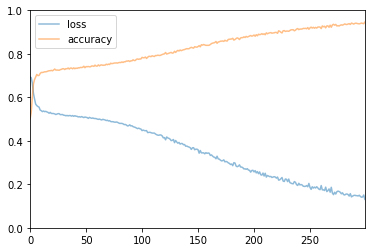

In [104]:
pd.DataFrame(model.history.history).plot(alpha=.5)
plt.gca().set_ylim(0,1)
plt.show()